In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
from tqdm import tqdm
import matplotlib as mpl
import time

def Lorentzian(eex, ee, gam):
    # returns the Lorentzian with mean ee and spread gam evaluated at the energies in eex.
    return (gam/np.pi)*(1/((eex-ee)**2 + gam**2))

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = 6,3.6
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams.update({'figure.autolayout': True})

In [3]:
# These functions define three examples for target DOS. 
# The target DOS is transformed to DOS_N depending on the number of sites N.
# DOS_N is the best approximation of DOS as a sum of N Lorentzians with means given by the N different eigenvalues of the Hamiltonian

def tophat(emax = 3, N = 16, samples = 300, gam = 0.01):
    eex = np.linspace(-6,6,samples)
    evs = np.linspace(-emax,emax,N)
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = gam)
        
    principal_target = 1/(2*emax)*np.array([1 if abs(ee)<emax else 0 for ee in eex])
    return (eex, target, principal_target)

             
def doublehat(emax = 4, emin = 1, N = 16, samples = 300):
    eex = np.linspace(-6,6,samples)
    evs = np.linspace(emin,emax,N//2)
    evs = np.sort(np.hstack((-evs,evs)))
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = 0.1)
        
    principal_target = 1/(2*(emax-emin))*np.array([1 if (abs(ee)<emax and abs(ee)>emin) else 0 for ee in eex])
    return (eex, target, principal_target)

def asymmetrichat(e0 = -3, e1 = 0, e2 = 1, e3 = 2, N = 16, samples = 300):
    eex = np.linspace(-6,6,samples)
    
    bandwidth = (e1-e0)+e3-e2
    evsL = np.linspace(e0,e1,int((e1-e0)/bandwidth *N))
    evsR = np.linspace(e2,e3,int((e3-e2)/bandwidth *N))
    evs = np.sort(np.hstack((evsL,evsR)))
    
    target = np.zeros(len(eex))
    for ev in evs:
        target += (1/N)*Lorentzian(eex, ev, gam = 0.1)
        
    principal_target = 1/(bandwidth)*np.array([1 if (ee<e1 and ee>e0) or (ee<e3 and ee>e2) else 0 for ee in eex])
    return (eex, target, principal_target)

In [4]:
class Model:
    """
    The Model class defines the problem. It specifies the size of the grid, the number of atoms, 
    the decay power of the hopping function and the target DOS to be approximated.
    """
    
    def __init__(self, N = 50, L =15, W = 15, alpha = 3, res = 0.1, target=tophat()):
        self.t = 1 
        self.N = N # Number of atoms
        self.L = L # LxW square grid of sites available to bee occupied by atoms 
        self.W = W
        self.alpha = alpha #Hopping between site i and j goes as 1/dist(i,j)^alpha where dist is the Euclidean distance
        self.eex, self.target, self.principal_target = target
        if self.principal_target.any == None:
            self.principal_target = self.target
        self.de = self.eex[1]-self.eex[0]
        self.res = res
        
        
        self.sites = [(x,y) for y in range(int(self.W//self.res)) for x in range(int(self.L//self.res))] # List of all available sites
        self.setup = {"t" : self.t, "alpha" : self.alpha, "eex" : self.eex, "res": res} # Parameters to pass to configuration class
        
        inds =  np.random.choice(np.arange(len(self.sites)), self.N, replace = False) # Initially occupied N sites chosen randomly
        self.occupied_sites = [self.sites[ind] for ind in inds]
        self.init_config = configuration(self.occupied_sites, setup = self.setup)   

    def optimize(self, runtime = 10, search_radius = 3, include_site = True, KPM = False):
        """
        A stochastic steepest descent alogrithm to get as close as possible to the the target DOS
        """
        def choose_site(): # Choose an occupied site at random
            ind =  np.random.choice(np.arange(len(self.occupied_sites)))
            return self.occupied_sites[ind]
        
        def find_empty_neighbours(site, search_radius, include_site = True): # Find all vacant neighbouring sites (up to 3 spaces away) to a given site
            p,q = site
            options = [(p+dp, q+dq) for dp in range(-search_radius, search_radius) for dq in range(-search_radius, search_radius)]
            options = [option for option in options if option in self.sites and option not in self.occupied_sites]
            if include_site:
                options.append(site)

            return options
        
        def calculate_error(config, KPM = KPM):
            if KPM:
                DOS = config.get_DOS_KPM()
            else:
                DOS = config.get_DOS()
            return self.de*np.linalg.norm(DOS - self.target)
        
        def find_best_move(site, options): #
            errs = []
            for option in options: # Get a list of potential new sites for site
                new_sites = list(self.occupied_sites)
                new_sites.remove(site)
                new_sites.append(option)
                
                new_config = configuration(new_sites, setup = self.setup)
                errs.append(calculate_error(new_config)) # Calculate the residual from each move
                
            new_site = options[errs.index(min(errs))]
            self.occupied_sites.remove(site) # Pick the new location with lowest error
            self.occupied_sites.append(new_site)
            
#             plt.plot(configuration(self.occupied_sites, setup = self.setup).get_DOS_KPM())
#             plt.show()
            return min(errs)
        
        initial_error = calculate_error(configuration(self.occupied_sites, setup = self.setup))
        err_log = [initial_error] # Logs residual error over the runtime
        for _ in tqdm(range(runtime)): 
            options = []
            while options == []: 
                site = choose_site() # pick a random site
                options = find_empty_neighbours(site, search_radius = search_radius, include_site = include_site) # Find available spaces around it

            err_log.append(find_best_move(site, options)) # Pick the available space with the lowest error
            
        return err_log
        
class configuration:
    """
    This class takes a particular set of occupied sites. The methods allow the construction of matrix Hamiltonians
    corresponding to it and the calculation of the Density of states.
    """
    def __init__(self, occupied_sites, setup = {}):
        self.occupied_sites = occupied_sites
        self.N = len(self.occupied_sites)
        
        self.t = setup["t"]
        self.alpha = setup["alpha"]
        self.eex = setup["eex"]
        self.res = setup["res"]
        
        self.make_system()
        
    def hopping(self, site1, site2):
        d = np.linalg.norm(site1.pos-site2.pos)
        return -self.t*d**(-self.alpha)
        
    def make_system(self):
        lat = kwant.lattice.square(a = self.res)
        syst = kwant.Builder()
        
        syst[(lat(*index) for index in self.occupied_sites)] = 0 * self.t
        syst[((lat(*index1), lat(*index2)) for index2 in self.occupied_sites for index1 in self.occupied_sites if index1 != index2)] = self.hopping
        self.syst = syst
        return self.syst
    
    def get_DOS(self, gam = 0.1):
        fsyst = self.syst.finalized()
        H = fsyst.hamiltonian_submatrix()
        evs, evecs = np.linalg.eig(H)
        self.DOS = [0]*len(self.eex)
        for ee in evs:
            self.DOS += (1/self.N)*Lorentzian(self.eex,ee,gam)
        return self.DOS
    
    def get_DOS_KPM(self):
        fsyst = self.syst.finalized()
        rho = kwant.kpm.SpectralDensity(fsyst, num_moments = 50, num_vectors = 100)
        self.DOS = (1/self.N)*rho(energy = self.eex)
        self.DOS[np.isnan(self.DOS)]=0
        return self.DOS
        

## test

In [201]:
target = tophat(samples = 500)

0.0250241756439209
0.058492183685302734


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/kwant/kpm.py:273: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


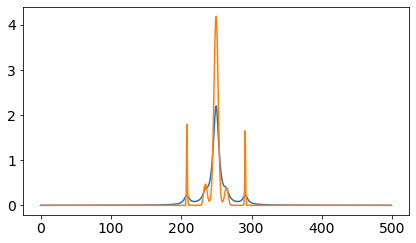

In [203]:
test = Model(N = 16, L =32, W = 32, alpha = 3, res = 1, target = target)
start = time.time()
plt.plot(test.init_config.get_DOS())
stop = time.time()
print(stop-start)

start = time.time()
plt.plot(test.init_config.get_DOS_KPM())
stop = time.time()
print(stop-start)

# Changing radii

In [204]:
# radii = [1,2,3,4,5,6]
radii = [2,3]
tests = []
err_logs = []
times = []
for radius in radii:
    np.random.seed(0)
    test = Model(N = 16, L =32, W = 32, alpha = 3, res = 0.1, target = target) 
    np.random.seed(None)
    start = time.time()
    err_log = test.optimize(10, search_radius = radius, KPM = True)
    stop = time.time()
    times.append(stop - start)
    print(stop - start)
    err_logs.append(err_log)
    tests.append(test) 

/opt/anaconda3/lib/python3.7/site-packages/kwant/kpm.py:273: RuntimeWarning: invalid value encountered in sqrt
  g_e = (np.pi * np.sqrt(1 - e) * np.sqrt(1 + e))


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:07,  1.15it/s]

 20%|██        | 2/10 [00:01<00:06,  1.15it/s]

 30%|███       | 3/10 [00:02<00:06,  1.16it/s]

 40%|████      | 4/10 [00:03<00:05,  1.19it/s]

 50%|█████     | 5/10 [00:04<00:04,  1.20it/s]

 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

 70%|███████   | 7/10 [00:05<00:02,  1.21it/s]

 80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

 90%|█████████ | 9/10 [00:07<00:00,  1.21it/s]

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

8.405210018157959




 10%|█         | 1/10 [00:01<00:16,  1.84s/it]

 20%|██        | 2/10 [00:03<00:14,  1.84s/it]

 30%|███       | 3/10 [00:05<00:13,  1.86s/it]

 40%|████      | 4/10 [00:07<00:11,  1.88s/it]

 50%|█████     | 5/10 [00:09<00:09,  1.87s/it]

 60%|██████    | 6/10 [00:11<00:07,  1.87s/it]

 70%|███████   | 7/10 [00:13<00:05,  1.87s/it]

 80%|████████  | 8/10 [00:14<00:03,  1.87s/it]

 90%|█████████ | 9/10 [00:16<00:01,  1.87s/it]

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

18.717005014419556


In [212]:
for err_log, test, radius in zip(err_logs, tests, radii):
    err_log_new = test.optimize(140, search_radius = radius, KPM = True)
    err_log += err_log_new 



  0%|          | 0/140 [00:00<?, ?it/s]

  1%|          | 1/140 [00:00<01:59,  1.17it/s]

  1%|▏         | 2/140 [00:01<02:00,  1.15it/s]

  2%|▏         | 3/140 [00:02<01:58,  1.16it/s]

  3%|▎         | 4/140 [00:03<01:57,  1.16it/s]

  4%|▎         | 5/140 [00:04<01:57,  1.15it/s]

  4%|▍         | 6/140 [00:05<01:54,  1.17it/s]

  5%|▌         | 7/140 [00:06<01:53,  1.17it/s]

  6%|▌         | 8/140 [00:06<01:53,  1.17it/s]

  6%|▋         | 9/140 [00:07<01:50,  1.18it/s]

  7%|▋         | 10/140 [00:08<01:47,  1.21it/s]

  8%|▊         | 11/140 [00:09<01:45,  1.22it/s]

  9%|▊         | 12/140 [00:10<01:46,  1.20it/s]

  9%|▉         | 13/140 [00:10<01:45,  1.20it/s]

 10%|█         | 14/140 [00:11<01:45,  1.20it/s]

 11%|█         | 15/140 [00:12<01:44,  1.20it/s]

 11%|█▏        | 16/140 [00:13<01:43,  1.19it/s]

 12%|█▏        | 17/140 [00:14<01:41,  1.22it/s]

 13%|█▎        | 18/140 [00:15<01:41,  1.20it/s]

 14%|█▎        | 19/140 [00:16<01:43,  1.17it/s]

 14%|█▍        |

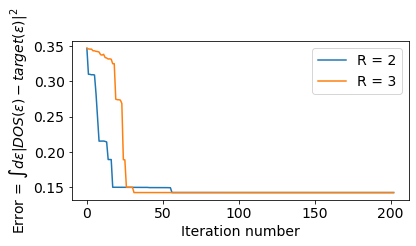

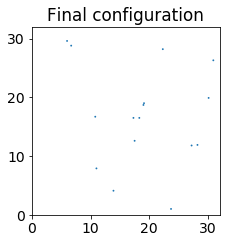

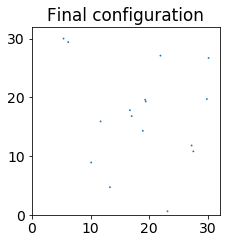

In [213]:
fig, ax = plt.subplots()
[ax.plot(err_logs[i], label = "R = {}".format(radii[i])) for i in range(len(tests))]
ax.set_ylabel("Error = $\\int d\\epsilon |DOS(\\epsilon) - target(\\epsilon)|^2$")
ax.set_xlabel("Iteration number")
ax.legend()
plt.savefig("Error.pdf")

for test in tests:
    fig, ax = plt.subplots()
    kwant.plot(configuration(test.occupied_sites, setup = test.setup).syst, hop_color = 'white', ax = ax, site_size = 0.5)
    ax.set_aspect('equal')
    ax.set_xlim((0,test.L))
    ax.set_ylim((0,test.W))
    ax.set_title("Final configuration")
    plt.show()
    
# fig, ax = plt.subplots()
# kwant.plot(configuration(tests[3].occupied_sites, setup = test.setup).syst, hop_color = 'white', ax = ax, site_size = 0.5)
# ax.set_aspect('equal')
# ax.set_xlim((0,test.L))
# ax.set_ylim((0,test.W))
# ax.set_title("Final configuration")
# plt.savefig("final-config.pdf")
# plt.show()

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


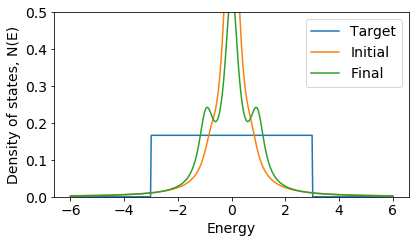

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


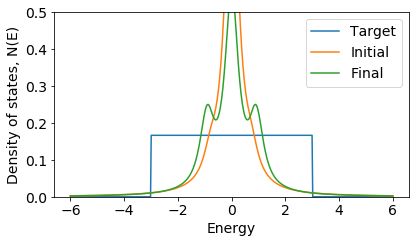

In [214]:
for test in tests:
    plt.plot(test.eex, test.principal_target, label = "Target")
    plt.plot(test.eex, test.init_config.get_DOS(gam = 0.3), label = "Initial")
    plt.plot(test.eex, configuration(test.occupied_sites, setup = test.setup).get_DOS(gam = 0.3), label = "Final")
#     plt.plot(test.eex, configuration(test.occupied_sites, setup = test.setup).get_DOS_KPM(), label = "Final")
    plt.legend()
    plt.xlabel("Energy")
    plt.ylabel("Density of states, N(E)")
    plt.ylim([0,0.5])
    plt.show()

# test = tests[3]
# plt.plot(test.eex, test.principal_target, label = "Target")
# plt.plot(test.eex, test.init_config.get_DOS(gam = 0.3), label = "Initial")
# plt.plot(test.eex, configuration(test.occupied_sites, setup = test.setup).get_DOS(gam = 0.2), label = "Final")
# #     plt.plot(test.eex, configuration(test.occupied_sites, setup = test.setup).get_DOS_KPM(), label = "Final")
# plt.legend()
# plt.xlabel("Energy")
# plt.ylabel("Density of states, N(E)")
# plt.ylim([0,0.5])
# plt.savefig("DOSes.pdf")
# plt.show()

In [210]:
# ini2 = tests[0].init_config
# ini3 = tests[1].init_config

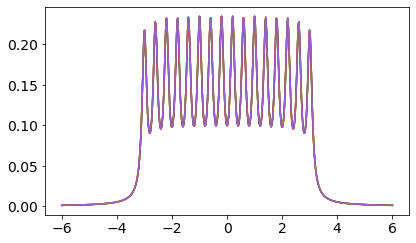

In [166]:
for test in tests:
    plt.plot(test.eex, test.target, label = "Target")

In [ ]:
# Issues
# 1) Need a way to consistently pick N atoms in target function
# 2) Add a way to add iterations to an optimizaation run
# 3) Calculate DOS via KPM
# 4) Can you find a set of discrete eigenvalues that best reproduce a DOS curve?

# Visualization

In [89]:
class nearest_neighbour_linear:
    def __init__(self, N):
        self.N = N
        
    def make_system(self, t=1):
        lat = kwant.lattice.chain(a = 1)
        syst = kwant.Builder()
        
        syst[(lat(i) for i in range(self.N))] = 0 * t
        syst[((lat(i), lat(i+1)) for i in range(self.N-1))] = -t
#         syst[(lat(self.N-1),lat(0))] = -t
        self.syst = syst
        return self.syst
        
    def get_evs(self):
        self.fsyst = self.syst.finalized()
        self.H = self.fsyst.hamiltonian_submatrix()
        self.evs, _ = np.linalg.eig(self.H)
        self.evs = np.real(np.sort(self.evs))
        return self.evs
        

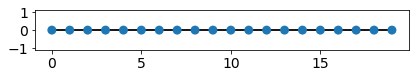

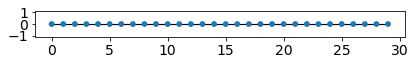

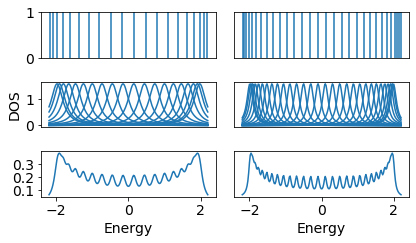

In [94]:
chain1 = nearest_neighbour_linear(20)
chain1.make_system()
kwant.plot(chain1.syst)
chain1.get_evs()

chain2 = nearest_neighbour_linear(30)
chain2.make_system()
kwant.plot(chain2.syst)
chain2.get_evs()

fig, axes = plt.subplots(3,2)

for ax, chain in zip(axes[0],(chain1,chain2)):
    for ev in chain.evs:
        ax.axvline(ev)
    ax.set_xticks([])
    ax.set_xlim([-2.2,2.2])

eex = np.linspace(-2.2,2.2,200)
for ax, chain, gam in zip(axes[1],(chain1,chain2), (0.2,0.1)):
    for ev in chain.evs:
        ax.plot(eex, Lorentzian(eex, ev, gam = gam), "C0")
    ax.set_xticks([])
        
for ax, chain, gam in zip(axes[2],(chain1,chain2), (0.1,0.05)):
    DOS = np.zeros(len(eex))
    for ev in chain.evs:
        DOS += (1/chain.N)*Lorentzian(eex, ev, gam = gam).real
    ax.plot(eex, DOS)
    ax.set_xlabel("Energy")
    
for ax in axes[:,1]:
    ax.set_yticks([])
    
axes[1,0].set_ylabel("DOS")

plt.savefig("DOS_representations.pdf")

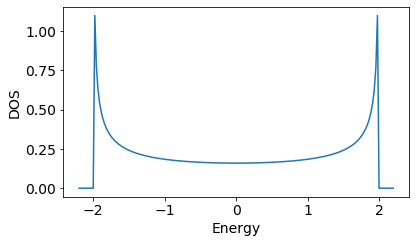

In [95]:
fig, ax = plt.subplots()

eex = np.linspace(-2.2,2.2,200)

def dos1D(eex):
    dos = []
    for ee in eex:   
        if np.abs(ee)<=2:
            dos.append(1/(2*np.pi)*1/np.sqrt(1 - ee**2/4))
        else:
            dos.append(0)
    return dos
    
ax.plot(eex,dos1D(eex))
ax.set_xlabel("Energy")
ax.set_ylabel("DOS")

plt.savefig("DOS_infinite.pdf")

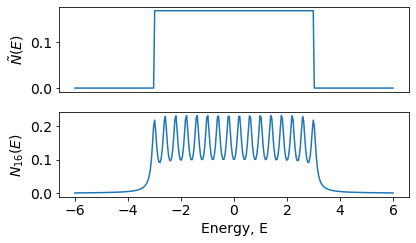

In [106]:
eex, target, principal_target = tophat()

fig, axes = plt.subplots(2)

axes[0].plot(eex, principal_target)
axes[0].set_xticks([])
axes[0].set_ylabel("$\\tilde{N}(E)$")

axes[1].plot(eex, target)
axes[1].set_xlabel("Energy, E")
axes[1].set_ylabel("$N_{16}(E)$")

plt.savefig("target.pdf")

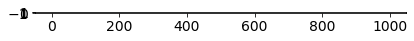

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


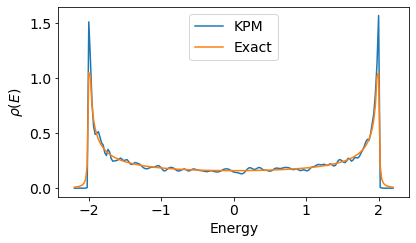

In [151]:
N = 1000
chain = nearest_neighbour_linear(N)
chain.make_system()
kwant.plot(chain.syst)
chain.get_evs()

# eex = np.linspace(-2.2,2.2,200)
# rho = kwant.kpm.SpectralDensity(chain.fsyst, num_moments = 200)
# densities = 1/N*rho(energy = eex)
# densities[np.isnan(densities)] = 0

DOS = np.zeros(len(eex))
for ev in chain.evs:
    DOS += (1/chain.N)*Lorentzian(eex, ev, gam = 0.01).real
ax.plot(eex, DOS)
ax.set_xlabel("Energy")

fig, ax = plt.subplots()
ax.plot(eex, densities, label = "KPM")
ax.plot(eex, DOS, label = "Exact")

ax.set_xlabel("Energy")
ax.set_ylabel("$\\rho(E)$")
ax.legend()

plt.savefig("KPM-benchmark.pdf")